In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import product
from collections import Counter
from scipy.stats import entropy
import matplotlib.pyplot as plt

In [43]:
GLOBAL_K_VALUE: int = 5

Load Data Files

In [44]:
def load_data(file_path: str) -> pd.DataFrame:
    """Load data from a CSV file."""
    return pd.read_csv(file_path)

In [45]:
# Anime dataset
anime_filtered = load_data('../data/clean/anime-dataset-filtered.csv')

# Recommendation datasets
user_based = load_data('../data/prediction/users-recommendations.csv')
content_based = load_data('../data/prediction/content-recommendations.csv')

# Validation dataset for 2025
watch_shrunk_25 = load_data('../data/clean/users-score-shrunk-2025.csv')

In [46]:
def filter_recommendations(recommendations: pd.DataFrame) -> pd.DataFrame:
    """Filter recommendations to include only valid anime IDs."""
    # rename rating if exists to score 
    if 'rating' in recommendations.columns:
        recommendations.rename(columns={'rating': 'score'}, inplace=True)
    return recommendations[['anime_id', 'user_id', 'score']]

In [47]:
user_based_filtered = filter_recommendations(user_based)
content_based_filtered = filter_recommendations(content_based)

Check for Missing Users

In [48]:
missing_users_user_based = set(user_based['user_id']).difference(set(watch_shrunk_25['user_id']))
missing_users_content_based = set(content_based['user_id']).difference(set(watch_shrunk_25['user_id']))

print(f"Missing users in user-based recommendations: {missing_users_user_based}")
print(f"Missing users in content-based recommendations: {missing_users_content_based}")

Missing users in user-based recommendations: set()
Missing users in content-based recommendations: set()


Metric Functions

In [49]:
def recall_at_k(y_true: np.ndarray, y_scores: np.ndarray, k: int) -> float:
    """Compute recall@k for binary classification."""
    top_k_idx = np.argsort(y_scores)[::-1][:k]
    tp_at_k = y_true[top_k_idx].sum()
    total_positives = y_true.sum()
    return tp_at_k / total_positives

def precision_at_k(y_true: np.ndarray, y_scores: np.ndarray, k: int) -> float:
    """Compute Precision@K for binary classification."""
    top_k_idx = np.argsort(y_scores)[::-1][:k]
    tp_at_k = y_true[top_k_idx].sum()
    return tp_at_k / k

def hitrate_at_k(y_true: np.ndarray, y_scores: np.ndarray, k: int) -> float:
    """Compute HitRate@K: 1 if any of the top-K is relevant, else 0."""
    top_k_idx = np.argsort(y_scores)[::-1][:k]
    return 1.0 if y_true[top_k_idx].sum() > 0 else 0.0

Calculate Quality Metrics

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get all unique anime IDs from recommendations
all_anime_ids = sorted(set(user_based_filtered['anime_id']) | set(content_based_filtered['anime_id']))
anime_id_to_idx = {aid: i for i, aid in enumerate(all_anime_ids)}

# Prepare actual watched anime per user in 2025
actual_watched = watch_shrunk_25.groupby('user_id')['anime_id'].apply(set).to_dict()

# Get common users between recommendations and actual watched
common_users_ub = set(user_based_filtered['user_id']) & set(actual_watched.keys())
common_users_cb = set(content_based_filtered['user_id']) & set(actual_watched.keys())

# Calculate metrics using your functions
ub_recalls = []
ub_precisions = []
cb_recalls = []
cb_precisions = []
ub_hitrates = []
cb_hitrates = []

# User-based metrics (use recommendation 'score' as importance)
for user_id in common_users_ub:
    # Get recommendations for this user (keep scores)
    user_recs_df = user_based_filtered[user_based_filtered['user_id'] == user_id][['anime_id', 'score']]

    # Create binary vectors
    y_true = np.array([1 if aid in actual_watched[user_id] else 0 for aid in all_anime_ids])
    y_scores = np.zeros(len(all_anime_ids))

    # Assign scores from the recommendation 'score' column
    for _, row in user_recs_df.iterrows():
        anime_id = row['anime_id']
        score = row.get('score', 0) if isinstance(row, dict) else row['score']
        if pd.isna(score):
            score = 0
        if anime_id in anime_id_to_idx:
            y_scores[anime_id_to_idx[anime_id]] = float(score)

    if y_true.sum() > 0:  # Only calculate if user has watched anime
        ub_recalls.append(recall_at_k(y_true, y_scores, GLOBAL_K_VALUE))
        ub_precisions.append(precision_at_k(y_true, y_scores, GLOBAL_K_VALUE))
        ub_hitrates.append(hitrate_at_k(y_true, y_scores, GLOBAL_K_VALUE))

# Content-based metrics (use recommendation 'score' as importance)
for user_id in common_users_cb:
    # Get recommendations for this user (keep scores)
    user_recs_df = content_based_filtered[content_based_filtered['user_id'] == user_id][['anime_id', 'score']]

    # Create binary vectors
    y_true = np.array([1 if aid in actual_watched[user_id] else 0 for aid in all_anime_ids])
    y_scores = np.zeros(len(all_anime_ids))

    # Assign scores from the recommendation 'score' column
    for _, row in user_recs_df.iterrows():
        anime_id = row['anime_id']
        score = row.get('score', 0) if isinstance(row, dict) else row['score']
        if pd.isna(score):
            score = 0
        if anime_id in anime_id_to_idx:
            y_scores[anime_id_to_idx[anime_id]] = float(score)

    if y_true.sum() > 0:
        cb_recalls.append(recall_at_k(y_true, y_scores, GLOBAL_K_VALUE))
        cb_precisions.append(precision_at_k(y_true, y_scores, GLOBAL_K_VALUE))
        cb_hitrates.append(hitrate_at_k(y_true, y_scores, GLOBAL_K_VALUE))

# Calculate averages (handle empty lists safely)
avg_ub_recall = np.mean(ub_recalls) if ub_recalls else 0.0
avg_ub_precision = np.mean(ub_precisions) if ub_precisions else 0.0
avg_cb_recall = np.mean(cb_recalls) if cb_recalls else 0.0
avg_cb_precision = np.mean(cb_precisions) if cb_precisions else 0.0

# HitRate@K (fraction of users with at least one hit in top-k)
ub_hitrate_k = np.mean(ub_hitrates) if ub_hitrates else 0.0
cb_hitrate_k = np.mean(cb_hitrates) if cb_hitrates else 0.0

# Calculate hit rate as percentage of recommendations that were actually watched
# Get all recommendations as sets per user
ub_user_recs = user_based_filtered.groupby('user_id')['anime_id'].apply(set).to_dict()
cb_user_recs = content_based_filtered.groupby('user_id')['anime_id'].apply(set).to_dict()

# Calculate what percentage of all recommendations were watched
ub_total_recs = 0
ub_watched_recs = 0
cb_total_recs = 0
cb_watched_recs = 0

for user_id in common_users_ub:
    recs = ub_user_recs[user_id]
    watched = actual_watched[user_id]
    ub_total_recs += len(recs)
    ub_watched_recs += len(recs & watched)

for user_id in common_users_cb:
    recs = cb_user_recs[user_id]
    watched = actual_watched[user_id]
    cb_total_recs += len(recs)
    cb_watched_recs += len(recs & watched)

ub_hit_rate_recs = ub_watched_recs / ub_total_recs if ub_total_recs > 0 else 0
cb_hit_rate_recs = cb_watched_recs / cb_total_recs if cb_total_recs > 0 else 0

# Print results
print(f"Recommendation Performance Metrics @ K={GLOBAL_K_VALUE}\n" + "="*50)
print(f"\nUser-Based Collaborative Filtering:")
print(f"  Recall@{GLOBAL_K_VALUE}:    {avg_ub_recall:.4f}")
print(f"  Precision@{GLOBAL_K_VALUE}: {avg_ub_precision:.4f}")
print(f"  HitRate@{GLOBAL_K_VALUE}:    {ub_hitrate_k:.4f}")
print(f"  Hit Rate (recs):      {ub_hit_rate_recs:.4f} ({ub_watched_recs}/{ub_total_recs})")
print(f"  Users evaluated: {len(ub_recalls)}")

print(f"\nContent-Based Filtering:")
print(f"  Recall@{GLOBAL_K_VALUE}:    {avg_cb_recall:.4f}")
print(f"  Precision@{GLOBAL_K_VALUE}: {avg_cb_precision:.4f}")
print(f"  HitRate@{GLOBAL_K_VALUE}:    {cb_hitrate_k:.4f}")
print(f"  Hit Rate (recs):      {cb_hit_rate_recs:.4f} ({cb_watched_recs}/{cb_total_recs})")
print(f"  Users evaluated: {len(cb_recalls)}")

Recommendation Performance Metrics @ K=5

User-Based Collaborative Filtering:
  Recall@5:    0.0005
  Precision@5: 0.0340
  HitRate@5:    0.1367
  Hit Rate (recs):      0.0353 (3842/108990)
  Users evaluated: 10899

Content-Based Filtering:
  Recall@5:    0.0009
  Precision@5: 0.0517
  HitRate@5:    0.1874
  Hit Rate (recs):      0.0467 (5113/109420)
  Users evaluated: 10942


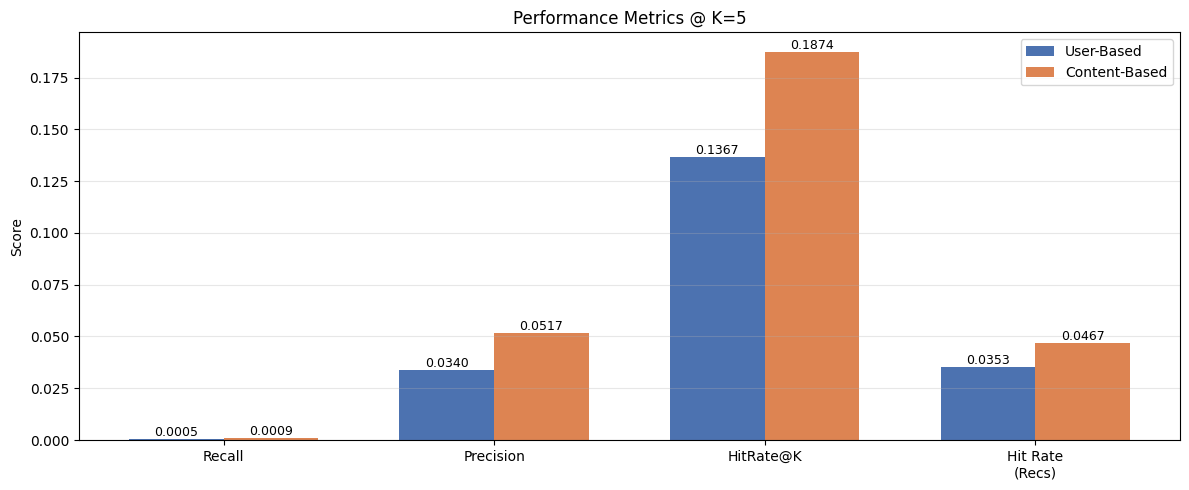

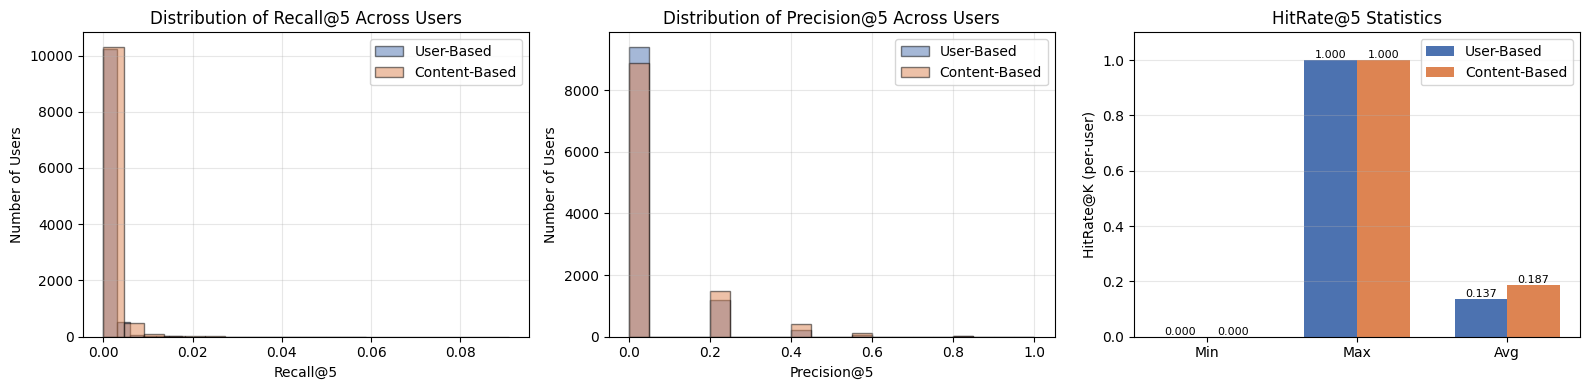

In [51]:
# Bar chart comparison
metrics_data = pd.DataFrame({
    'Metric': ['Recall', 'Precision', 'HitRate@K', 'Hit Rate\n(Recs)'],
    'User-Based': [avg_ub_recall, avg_ub_precision, ub_hitrate_k, ub_hit_rate_recs],
    'Content-Based': [avg_cb_recall, avg_cb_precision, cb_hitrate_k, cb_hit_rate_recs]
})

fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(metrics_data['Metric']))
width = 0.35

bars1 = ax.bar(x - width/2, metrics_data['User-Based'], width, label='User-Based', color='#4C72B0')
bars2 = ax.bar(x + width/2, metrics_data['Content-Based'], width, label='Content-Based', color='#DD8452')

ax.set_ylabel('Score')
ax.set_title(f'Performance Metrics @ K={GLOBAL_K_VALUE}')
ax.set_xticks(x)
ax.set_xticklabels(metrics_data['Metric'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Distribution plots for individual user metrics
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Recall distributions
axes[0].hist(ub_recalls, bins=20, alpha=0.5, label='User-Based', color='#4C72B0', edgecolor='black')
axes[0].hist(cb_recalls, bins=20, alpha=0.5, label='Content-Based', color='#DD8452', edgecolor='black')
axes[0].set_xlabel(f'Recall@{GLOBAL_K_VALUE}')
axes[0].set_ylabel('Number of Users')
axes[0].set_title(f'Distribution of Recall@{GLOBAL_K_VALUE} Across Users')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Precision distributions
axes[1].hist(ub_precisions, bins=20, alpha=0.5, label='User-Based', color='#4C72B0', edgecolor='black')
axes[1].hist(cb_precisions, bins=20, alpha=0.5, label='Content-Based', color='#DD8452', edgecolor='black')
axes[1].set_xlabel(f'Precision@{GLOBAL_K_VALUE}')
axes[1].set_ylabel('Number of Users')
axes[1].set_title(f'Distribution of Precision@{GLOBAL_K_VALUE} Across Users')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Hit rate as binary (0 or 1) per user
ub_hits = [int(h > 0) for h in ub_hitrates]
cb_hits = [int(h > 0) for h in cb_hitrates]

# Calculate statistics
ub_stats = {'min': min(ub_hits) if ub_hits else 0, 'max': max(ub_hits) if ub_hits else 0, 'avg': float(np.mean(ub_hits)) if ub_hits else 0.0}
cb_stats = {'min': min(cb_hits) if cb_hits else 0, 'max': max(cb_hits) if cb_hits else 0, 'avg': float(np.mean(cb_hits)) if cb_hits else 0.0}

# Create grouped bar chart for hit rate
categories = ['Min', 'Max', 'Avg']
ub_values = [ub_stats['min'], ub_stats['max'], ub_stats['avg']]
cb_values = [cb_stats['min'], cb_stats['max'], cb_stats['avg']]

x_pos = np.arange(len(categories))
width = 0.35

bars1 = axes[2].bar(x_pos - width/2, ub_values, width, label='User-Based', color='#4C72B0')
bars2 = axes[2].bar(x_pos + width/2, cb_values, width, label='Content-Based', color='#DD8452')

axes[2].set_ylabel('HitRate@K (per-user)')
axes[2].set_title(f'HitRate@{GLOBAL_K_VALUE} Statistics')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(categories)
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)
axes[2].set_ylim([0, 1.1])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[2].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


Calculate Diversity Metrics

In [52]:
def diversity_per_user(recommended_anime_ids: list[int], anime_df: pd.DataFrame, metric_columns: list[str]) -> float:
    """ Calculate the diversity (Shannon entropy) for a list of recommended anime IDs """
    filtered = anime_df[anime_df['anime_id'].isin(recommended_anime_ids)]
    combined_list = []
    for _, row in filtered[metric_columns].dropna().iterrows():
        # For each column, split by comma and strip
        split_columns = [
            [v.strip() for v in str(row[col]).split(',') if v.strip()] if pd.notnull(row[col]) else []
            for col in metric_columns
        ]    
        for combo in product(*split_columns):
            combined_list.append(','.join(combo))
    if not combined_list:
        return 0.0
    combined_counts = Counter(combined_list)
    combined_freqs = np.array(list(combined_counts.values())) / sum(combined_counts.values())
    return entropy(combined_freqs)

In [53]:
def calculate_diversity(recommendation: pd.DataFrame, anime_df: pd.DataFrame, metric_columns: list[str]) -> dict[int, float]:
    """ Calculate the Shannon entropy for all users in the list """
    user_col_diversity = {}
    for user_id, group in recommendation.groupby('user_id'):
        rec_anime_ids = group['anime_id'].values
        user_col_diversity[user_id] = diversity_per_user(rec_anime_ids, anime_df, metric_columns)
    return user_col_diversity

In [54]:
entropy_tests = {
    "Genre Only": ['Genres'],
    "Themes Only": ['Themes'],
    "Genre + Themes": ['Genres', 'Themes'],
    "Genre + Themes + Demographics": ['Genres', 'Themes', 'Demographics', ],
    "All": ['Genres', 'Themes', 'Demographics', 'Type', 'Studios']
}

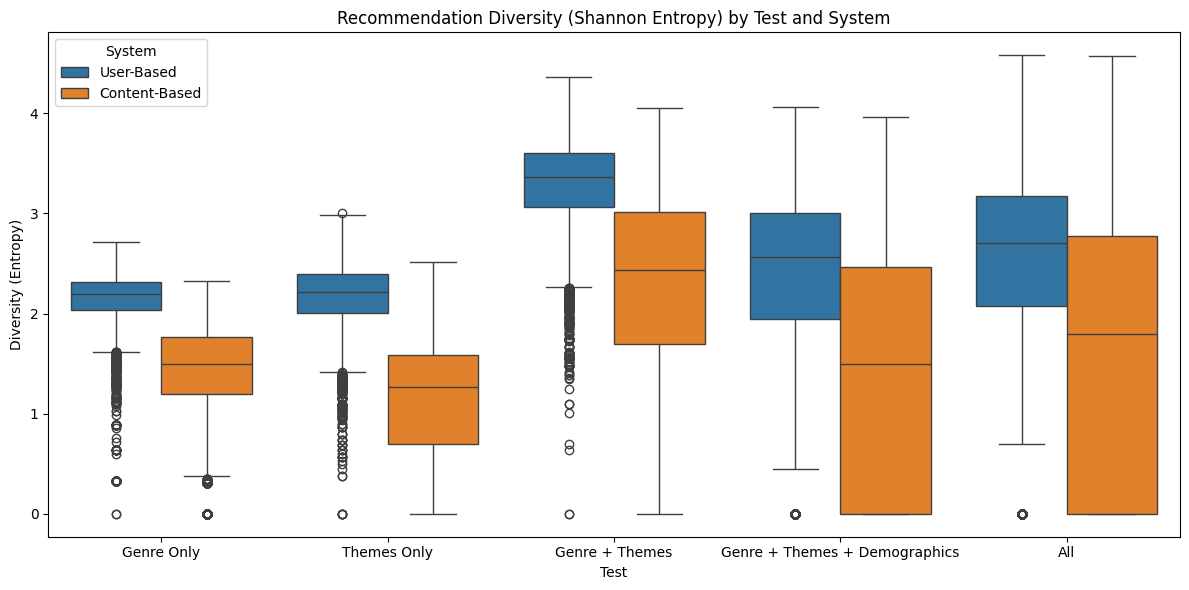

In [55]:
# Run diversity calculations for each test for both user-based and content-based
ub_diversity_results = {}
cb_diversity_results = {}
for test_name, cols in entropy_tests.items():
    ub_diversity_results[test_name] = calculate_diversity(user_based_filtered, anime_filtered, cols)
    cb_diversity_results[test_name] = calculate_diversity(content_based_filtered, anime_filtered, cols)

# Prepare data for plotting
plot_data = []
for test_name, user_divs in ub_diversity_results.items():
    for user_id, div in user_divs.items():
        plot_data.append({'Test': test_name, 'User': user_id, 'Diversity': div, 'System': 'User-Based'})
for test_name, user_divs in cb_diversity_results.items():
    for user_id, div in user_divs.items():
        plot_data.append({'Test': test_name, 'User': user_id, 'Diversity': div, 'System': 'Content-Based'})

plot_df = pd.DataFrame(plot_data)

# Boxplot of diversity values for each test and system
plt.figure(figsize=(12, 6))
ax = plt.gca()
# Use seaborn for grouped boxplot
sns.boxplot(x='Test', y='Diversity', hue='System', data=plot_df, ax=ax)
plt.title('Recommendation Diversity (Shannon Entropy) by Test and System')
plt.xlabel('Test')
plt.ylabel('Diversity (Entropy)')
plt.legend(title='System')
plt.tight_layout()
plt.show()